In [ ]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import pandas as pd
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder


In [ ]:
nltk.download("stopwords")
stop_words = set(nltk.corpus.stopwords.words("english"))

fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")
new_df = pd.read_csv("fake_or_real_news.csv")

fake_df["label"] = 0
true_df["label"] = 1

new_df["label"] = new_df["label"].map({"FAKE": 0, "REAL": 1})

df = pd.concat([fake_df, true_df, new_df[["title", "text", "label"]]], axis=0).reset_index(drop=True)

df = df[["title", "text", "label"]]

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

def manual_tokenize(text):
    tokens = []
    current_word = ""
    for char in text:
        if char.isalnum():
            current_word += char.lower()
        elif current_word:
            tokens.append(current_word)
            current_word = ""
    if current_word:
        tokens.append(current_word)
    return tokens

def clean_text(text):
    text = str(text).lower()

    text = re.sub(r'\b(?:getty images|via twitter|pool/getty images|afp/getty images|reuters|ap photo)\b', '', text, flags=re.IGNORECASE)
    symbols_to_remove = ["'", "\[", ":", "-", "_", "+", "?", ",", "\]", ".", "â€˜", "â€™",
                         "@", "!", "$", "=", "(", ")", "/", "\\", "&", "#"]
    for sym in symbols_to_remove:
        text = text.replace(sym, "")

    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = manual_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

df.dropna(subset=["clean_text"], inplace=True)
df = df[df["clean_text"].str.strip() != ""]

df.to_csv("clean_news.csv", index=False)

print("Файл clean_news.csv створено успішно.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Файл clean_news.csv створено успішно.


In [ ]:
print(df["clean_text"].isna().sum())
print(df["clean_text"].dtype)

0
object


In [7]:
df = pd.read_csv("clean_news.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_16728\1711818089.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Клас новини', y='Кількість', data=class_counts, palette=colors1)
C:\Users\HP\AppData\Local\Temp\ipykernel_16728\1711818089.py:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(x='Клас новини', y='Кількість', data=class_counts, palette=colors1)


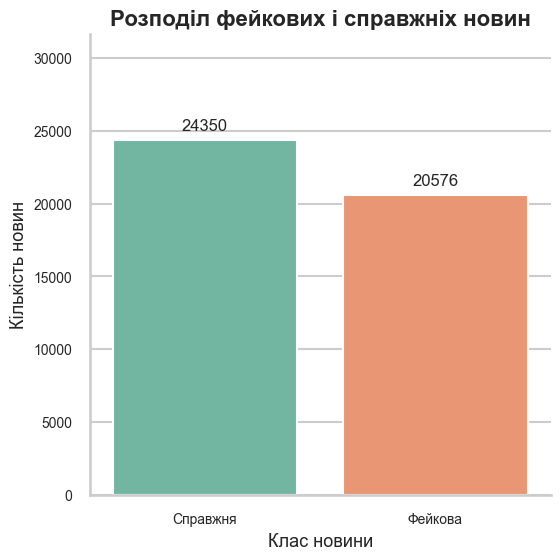

C:\Users\HP\AppData\Local\Temp\ipykernel_16728\1711818089.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Клас новини', y='Середня довжина (слів)', data=avg_lengths, palette=colors2)
C:\Users\HP\AppData\Local\Temp\ipykernel_16728\1711818089.py:32: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax2 = sns.barplot(x='Клас новини', y='Середня довжина (слів)', data=avg_lengths, palette=colors2)


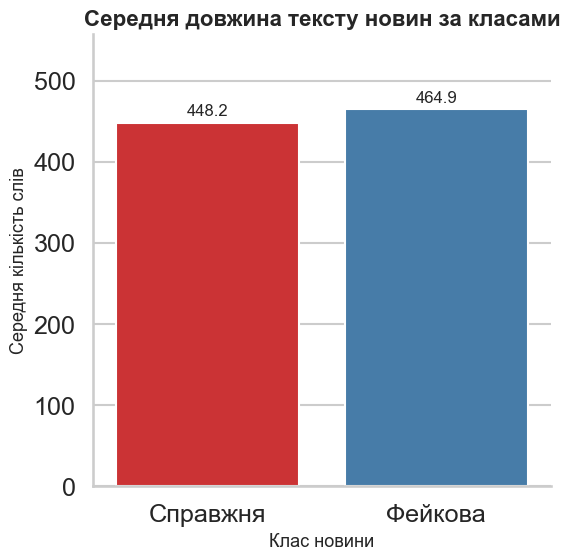

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", font_scale=1.1)
colors1 = sns.color_palette("Set2")
colors2 = sns.color_palette("Set1")

plt.figure(figsize=(6, 6))
ax = sns.barplot(x='Клас новини', y='Кількість', data=class_counts, palette=colors1)

for i, row in class_counts.iterrows():
    ax.text(i, row['Кількість'] + 500, f"{int(row['Кількість'])}",
            ha='center', va='bottom', fontsize=12)

max_count = class_counts['Кількість'].max()
ax.set_ylim(0, max_count * 1.3)

ax.tick_params(axis='both', labelsize=10)

ax.set_xlabel("Клас новини", fontsize=13)
ax.set_ylabel("Кількість новин", fontsize=13)
plt.title('Розподіл фейкових і справжніх новин', fontsize=16, weight='bold')
sns.despine()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
ax2 = sns.barplot(x='Клас новини', y='Середня довжина (слів)', data=avg_lengths, palette=colors2)

for i, row in avg_lengths.iterrows():
    ax2.text(i, row['Середня довжина (слів)'] + 5, f"{row['Середня довжина (слів)']:.1f}",
             ha='center', va='bottom', fontsize=12)

max_len = avg_lengths['Середня довжина (слів)'].max()
ax2.set_ylim(0, max_len * 1.2)

max_count = class_counts['Кількість'].max()
ax.set_ylim(0, max_count * 1.3)

ax.tick_params(axis='both', labelsize=10)

ax2.set_xlabel("Клас новини", fontsize=13)
ax2.set_ylabel("Середня кількість слів", fontsize=13)
plt.title('Середня довжина тексту новин за класами', fontsize=16, weight='bold')
sns.despine()
plt.tight_layout()
plt.show()


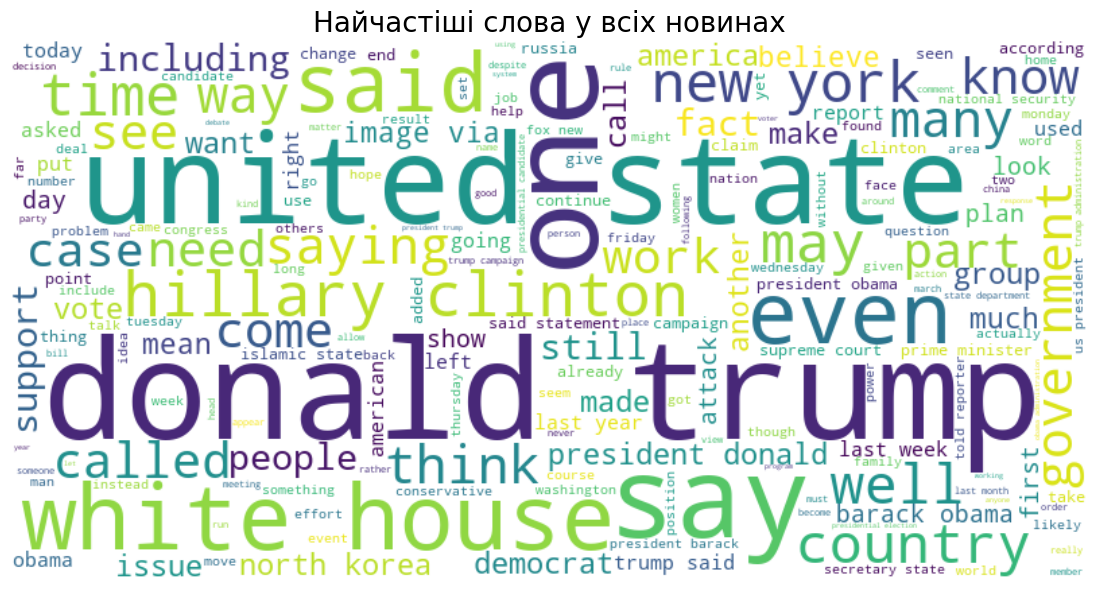

In [37]:
text_all = " ".join(df["clean_text"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Найчастіші слова у всіх новинах", fontsize=20)
plt.show()


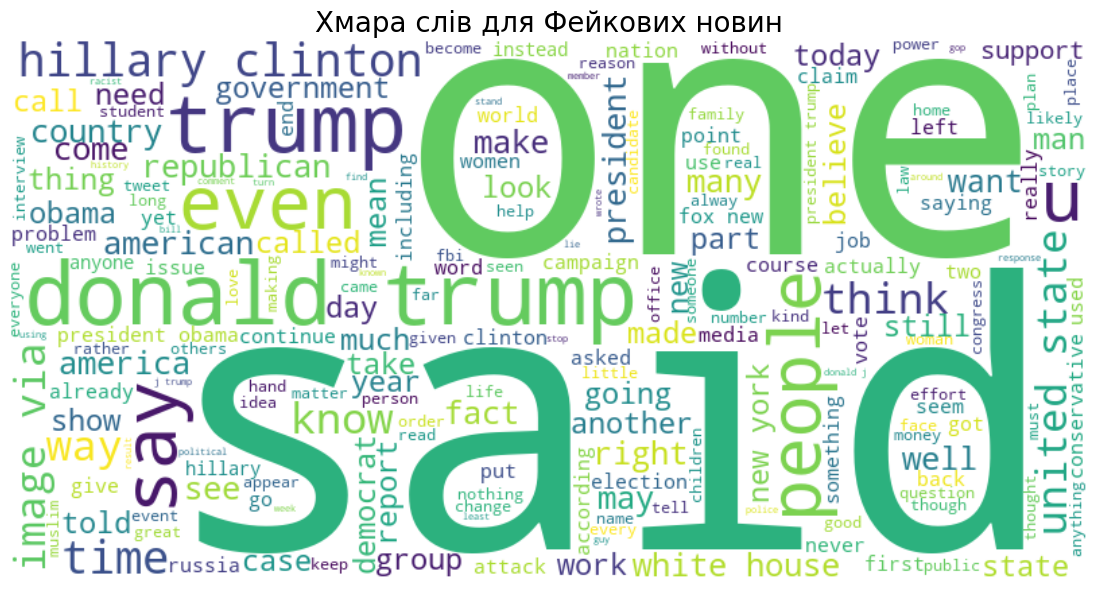

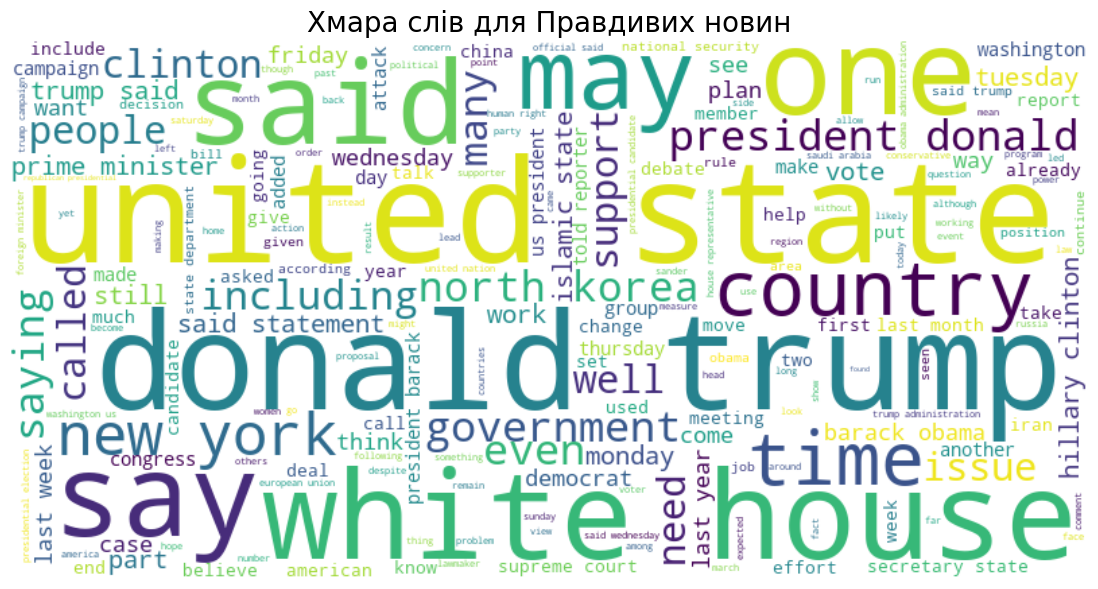

In [38]:
for label in [0, 1]:
    label_text = " ".join(df[df["label"] == label]["clean_text"].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(label_text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Хмара слів для {'Фейкових' if label == 0 else 'Правдивих'} новин", fontsize=20)
    plt.show()


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re

# топ-слова
top_words =  [
    "donald trump",
    "hillary clinton",
    "united states",
    "white house",
    "north korea",
    "government",
    "new york",
    "russia",
    "obama",
    "republican",
    "democrat",
    "china",
    "fbi",
    "president",
    "secretary state",
    "prime minister",
    "election",
    "congress",
    "american",
    "nuclear",
    "media",
    "news",
    "campaign",
    "investigation",
    "press"
]


for word in top_words:
    df[f"kw_{word}"] = df["clean_text"].apply(lambda x: int(bool(re.search(rf"\b{re.escape(word)}\b", x))))

df["top_word_hits"] = df[[f"kw_{word}" for word in top_words]].sum(axis=1)

print(df["top_word_hits"].value_counts().sort_index())

X = df["clean_text"].values
y = df["label"].values
stratify_column = df["top_word_hits"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=stratify_column, test_size=0.2, random_state=42
)

train_df = pd.DataFrame({"clean_text": X_train, "label": y_train})
test_df = pd.DataFrame({"clean_text": X_test, "label": y_test})

train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("Дані успішно розділені та збережені!")


top_word_hits
0     3503
1     5153
2     5872
3     6034
4     5576
5     4681
6     3753
7     3001
8     2260
9     1666
10    1170
11     797
12     544
13     341
14     219
15     141
16      86
17      68
18      25
19      18
20       8
22      10
Name: count, dtype: int64
✅ Дані успішно розділені та збережені!


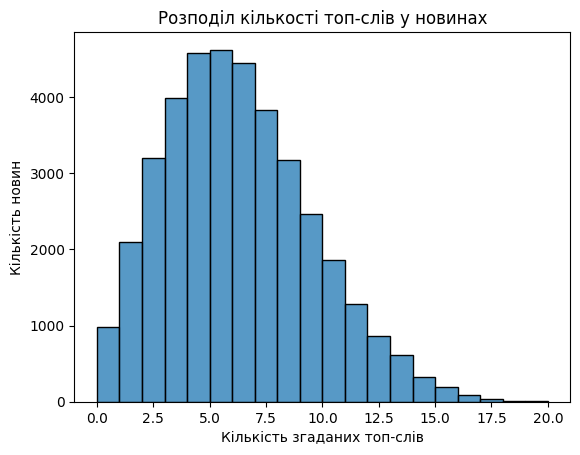

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["top_word_hits"], bins=range(0, max(df["top_word_hits"])+2))
plt.title("Розподіл кількості топ-слів у новинах")
plt.xlabel("Кількість згаданих топ-слів")
plt.ylabel("Кількість новин")
plt.show()

In [7]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

train_sentences = train_df["clean_text"].apply(text_to_word_sequence).tolist()
test_sentences = test_df["clean_text"].apply(text_to_word_sequence).tolist()



In [8]:
w2v_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)


In [9]:
embedding_dim = 100
vocab = w2v_model.wv.key_to_index
word_index = {word: i+1 for i, word in enumerate(vocab)}  # +1 для зарезервованого 0

def texts_to_sequences(tokenized_texts, word_index):
    sequences = []
    for tokens in tokenized_texts:
        seq = [word_index.get(word, 0) for word in tokens]
        sequences.append(seq)
    return sequences

X_train_seq = texts_to_sequences(train_sentences, word_index)
X_test_seq = texts_to_sequences(test_sentences, word_index)

MAX_SEQUENCE_LENGTH = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]




In [ ]:

w2v_model.save("word2vec_model.model")
import pickle

with open("word_index.pkl", "wb") as f:
    pickle.dump(word_index, f)



In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
y_train = train_df["label"].values
y_test = test_df["label"].values

model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    verbose=2
)


Epoch 1/5
562/562 - 37s - 66ms/step - accuracy: 0.9169 - loss: 0.2076 - val_accuracy: 0.9476 - val_loss: 0.1471
Epoch 2/5
562/562 - 29s - 51ms/step - accuracy: 0.9441 - loss: 0.1443 - val_accuracy: 0.9525 - val_loss: 0.1370
Epoch 3/5
562/562 - 30s - 53ms/step - accuracy: 0.9541 - loss: 0.1217 - val_accuracy: 0.9540 - val_loss: 0.1249
Epoch 4/5
562/562 - 30s - 54ms/step - accuracy: 0.9588 - loss: 0.1071 - val_accuracy: 0.9579 - val_loss: 0.1192
Epoch 5/5
562/562 - 32s - 57ms/step - accuracy: 0.9642 - loss: 0.0947 - val_accuracy: 0.9593 - val_loss: 0.1166


In [21]:
y_train = train_df["label"].values
y_test = test_df["label"].values

In [ ]:

model = load_model("fake_news_model3.h5")


In [32]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"📊 Тестова точність: {acc * 100:.2f}%")


281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9585 - loss: 0.1208
📊 Тестова точність: 95.93%


In [2]:
model.save("fake_news_model3.h5")




NameError: name 'word_index' is not defined

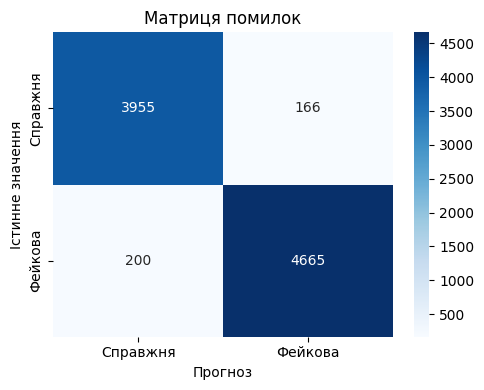

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Справжня', 'Фейкова'],
            yticklabels=['Справжня', 'Фейкова'])
plt.xlabel('Прогноз')
plt.ylabel('Істинне значення')
plt.title('Матриця помилок')
plt.tight_layout()
plt.show()


In [24]:
wrong_indices = np.where(y_pred != y_test)[0]

# Завантажити оригінальні тексти (можна з test_df)
wrong_examples = test_df.iloc[wrong_indices].copy()
wrong_examples['predicted'] = y_pred[wrong_indices]

# Переклад числових міток
label_map = {0: 'Фейкова', 1: 'Справжня'}
wrong_examples['label'] = wrong_examples['label'].map(label_map)
wrong_examples['predicted'] = wrong_examples['predicted'].map(label_map)

# Вивід перших 5 прикладів
print("❌ Неправильно класифіковані новини:")
print(wrong_examples[['clean_text', 'label', 'predicted']].head(5))


MemoryError: Unable to allocate 612. MiB for an array with shape (40122626, 2) and data type int64

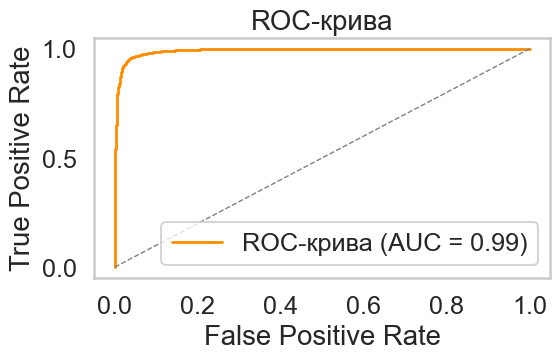

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC-крива (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-крива")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


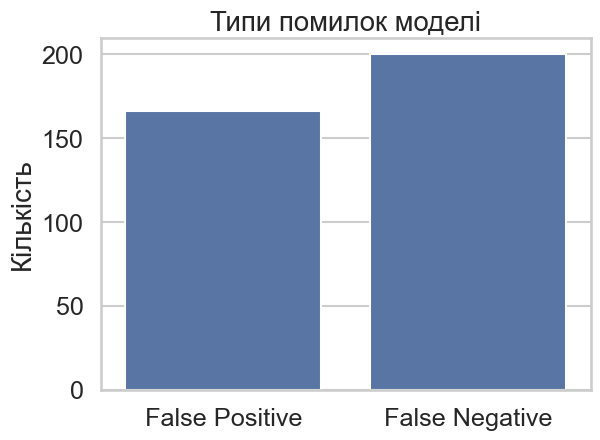

In [37]:
import collections

errors = []
for yt, yp in zip(y_test, y_pred):
    if yt == 0 and yp == 1:
        errors.append("False Positive")
    elif yt == 1 and yp == 0:
        errors.append("False Negative")
error_counts = collections.Counter(errors)

sns.barplot(x=list(error_counts.keys()), y=list(error_counts.values()))
plt.title("Типи помилок моделі")
plt.ylabel("Кількість")
plt.tight_layout()
plt.show()


281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
 Метрики моделі:
        Accuracy  Precision   Recall  F1-score
Модель   0.95927   0.965639  0.95889  0.962252


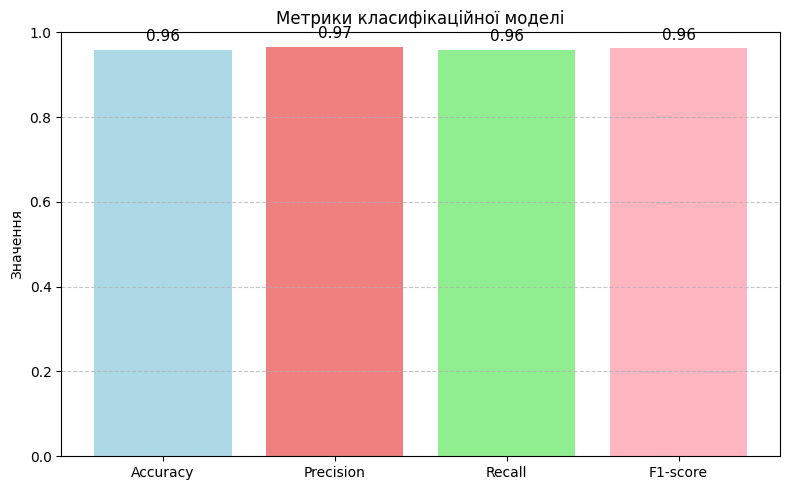

In [17]:
# Прогнози
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# --- 📊 Таблиця метрик ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-score': f1_score(y_test, y_pred)
}


metrics_df = pd.DataFrame(metrics, index=['Модель'])
print(" Метрики моделі:")
print(metrics_df)

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['lightblue', 'lightcoral', 'lightgreen', 'lightpink'])
plt.ylim(0, 1)
plt.title("Метрики класифікаційної моделі")
plt.ylabel("Значення")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Додавання значень над стовпцями
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()
